# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
tf.random.set_seed(42)

# Data

## Image path

In [3]:
train_dir = "/content/drive/MyDrive/Tomato_diseases/tomato/train"
test_dir = "/content/drive/MyDrive/Tomato_diseases/tomato/val"

## Data Rescaling and augmentation

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
    input_shape=(112, 112, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

## Load datasets (Shuffle and prefetch)

In [5]:
import tensorflow as tf

IMG_SIZE = (112, 112)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=42
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = test_data.class_names
valid_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 10017 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


# Create Checkpoint

In [ ]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

# Create model

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

])

## Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                        

## Compile model

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

## Fit the model

In [ ]:
history = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

# Create plot_loss_curve function

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## plot the model

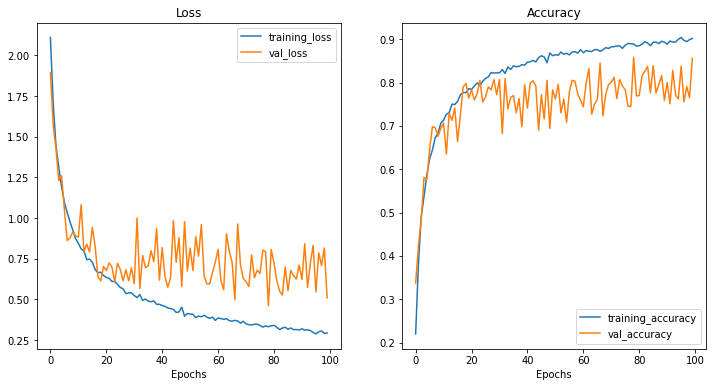

In [ ]:
plot_loss_curves(history)

# Load model

In [10]:
load_model = tf.keras.models.load_model("/content/drive/MyDrive/Tomato_diseases/tomato_disease_model.h5")

## Evaluate loaded model with test_data

In [ ]:
load_model.evaluate(train_data),load_model.evaluate(test_data)

32/32 [==============================] - 288s 7s/step - loss: 0.0776 - accuracy: 0.9820


([0.03169781714677811, 0.9905161261558533],
 [0.07763724029064178, 0.9819999933242798])

# Prediction & visualize

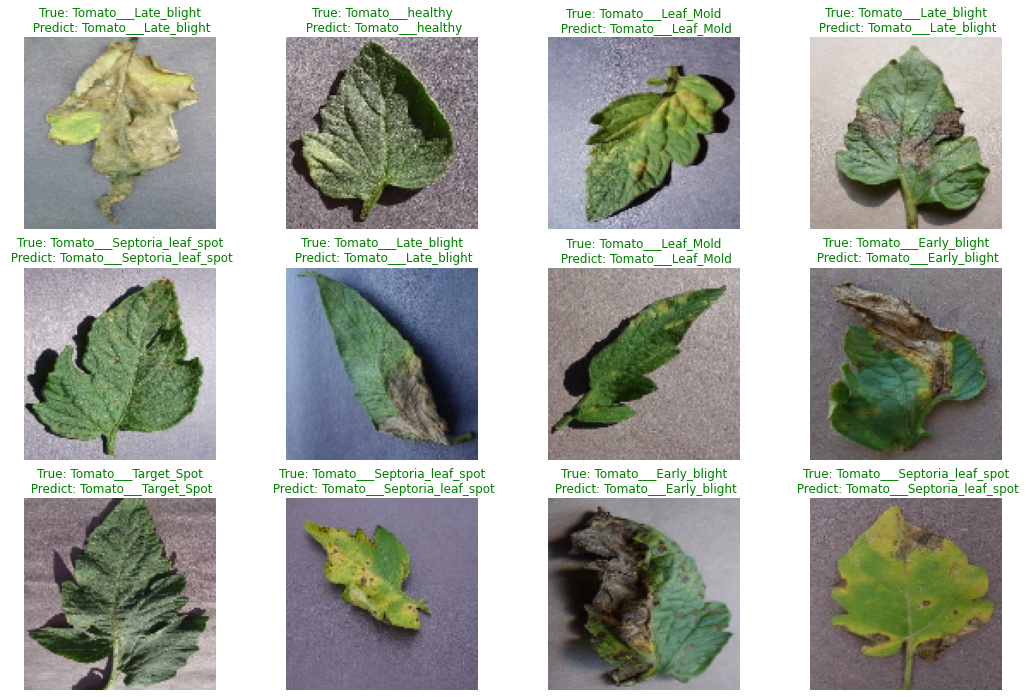

In [ ]:
plt.figure(figsize=(18,12))
for image_batch,label_batch in test_data.take(1):
    predictions = load_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

# User-given Image Prediction

In [11]:
def identify_disease(image, disease_list, IMG_SIZE = (112, 112)):
    img = Image.open(image)
    img_resized = img.resize(IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img_resized)
    img_array = np.array([img_array])
    prediction = load_model.predict(img_array)
    probability_array = prediction[0]

    max_index = 0
    max_element = probability_array[0]
    for i in range(len(probability_array)):
        if max_element < probability_array[i]:
            max_element = probability_array[i]
            max_index = i
    return disease_list[max_index]

In [14]:
image_path = '/content/b6bdfe3b-7cb9-48e1-86b2-4ccaf3770af1___RS_Erly.B 9477.JPG'

disease_list = ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 
            'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Two-spottedSpiderMite', 
            'Tomato_Target_Spot', 'Tomato_mosaic_virus', 'Tomato_Yellow_Leaf_Curl_Virus']

In [15]:
identified_disease = identify_disease(image_path, disease_list)
print(f'Probable identified disease is: {identified_disease}')

Probable identified disease is: Tomato_Early_blight
